# P6 Analyser les ventes d'une librairie avec Python

### importation des packages

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew

In [2]:
# création des dataframes
df_customers = pd.read_excel('customers.xlsx')
df_products = pd.read_excel('products.xlsx')
df_transactions = pd.read_excel('transactions2.xlsx')

## exploration des données

In [3]:
df_customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
# je renomme la colonne client_id
df_customers.columns = ['id_client', 'sex', 'birth']
df_transactions.columns = ['id_prod','date','id_session','id_client']

In [5]:
df_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [6]:
df_transactions.head()

,id_prod,date,id_session,id_client
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033


## Analyse des différents indicateurs de vente

### Analyse du CA

In [7]:
# Je créer une table chiffre d'affaire par transaction
df_transaction_avec_info_prod = df_transactions.merge(df_products, how='outer',indicator=True)
df_transaction_avec_info_prod.head()

,id_prod,date,id_session,id_client,price,categ,_merge
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,11.99,0.0,both
1,0_1259,2021-03-01 10:27:10.675023,s_202,c_1599,11.99,0.0,both
2,0_1259,2021-03-04 07:26:01.343183,s_1519,c_1609,11.99,0.0,both
3,0_1259,2021-03-05 13:32:43.907997,s_2114,c_107,11.99,0.0,both
4,0_1259,2021-03-07 09:47:05.272864,s_2976,c_4215,11.99,0.0,both


In [8]:
df_transactions.shape

(679332, 4)

In [9]:
df_products.shape

(3287, 3)

In [10]:
df_transaction_avec_info_prod.shape
# je constate que des données n'ont pas de correspondances

(679354, 7)

In [11]:
df_transaction_avec_info_prod[df_transaction_avec_info_prod['_merge']=='left_only']

,id_prod,date,id_session,id_client,price,categ,_merge
6514,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,NaN,NaN,left_only
6515,0_2245,2021-03-02 15:55:49.728644,s_783,c_8060,NaN,NaN,left_only
6516,0_2245,2021-03-07 20:00:01.525768,s_3159,c_1189,NaN,NaN,left_only
6517,0_2245,2021-03-23 15:57:44.266387,s_10427,c_5869,NaN,NaN,left_only
6518,0_2245,2021-03-28 10:46:04.804784,s_12567,c_966,NaN,NaN,left_only
...,...,...,...,...,...,...,...
6730,0_2245,2023-02-10 11:54:44.891532,s_339558,c_6952,NaN,NaN,left_only
6731,0_2245,2023-02-16 05:53:01.627491,s_342289,c_7954,NaN,NaN,left_only
6732,0_2245,2023-02-17 03:03:12.668129,s_342683,c_1533,NaN,NaN,left_only
6733,0_2245,2023-02-17 20:34:06.230094,s_343000,c_1551,NaN,NaN,left_only


In [12]:
df_transaction_avec_info_prod[df_transaction_avec_info_prod['_merge']=='left_only'].groupby('id_prod').count()
# le produit 0_2245 n'a pas de correspondance dans la table produit

,date,id_session,id_client,price,categ,_merge
id_prod,,,,,,
0_2245,221,221,221,0,0,221


In [13]:
# j'ajoute le produit dans la table produit, je lui donne pour prix la moyenne des prix
df_products.loc[3288]=["0_2245",round(df_products[df_products['price']<100000]['price'].mean(),2),0]
df_products.loc[3288]
# il faut penser à refaire les jointures

id_prod    0_2245
price       21.86
categ           0
Name: 3288, dtype: object

In [14]:
# je refais la jointure pour avoir les nouvelles données
# je fais cette fois-ci une "left join" pour ne pas garder les produits qui n'ont pas de 
# correspondance dans la table transaction, ces produits n'ont pas été achetés
df_transaction_avec_info_prod = df_transactions.merge(df_products, how='left',indicator=True)

In [15]:
# je modifie la colonne date pour qu'elle occupe moins d'espace de stockage
df_transaction_avec_info_prod['date'] = df_transaction_avec_info_prod['date'].str[:19]
# pour étudier le chiffre d'affaire en fonction du temps, j'ajoute des colonnes
df_transaction_avec_info_prod['year'] = df_transaction_avec_info_prod['date'].str[:4]
df_transaction_avec_info_prod['month'] = df_transaction_avec_info_prod['date'].str[5:7]
df_transaction_avec_info_prod['day'] = df_transaction_avec_info_prod['date'].str[8:10]
df_transaction_avec_info_prod['time'] = df_transaction_avec_info_prod['date'].str[11:19]
df_transaction_avec_info_prod.head()

,id_prod,date,id_session,id_client,price,categ,_merge,year,month,day,time
0,0_1259,2021-03-01 00:01:07,s_1,c_329,11.99,0,both,2021,03,01,00:01:07
1,0_1390,2021-03-01 00:02:26,s_2,c_664,19.37,0,both,2021,03,01,00:02:26
2,0_1352,2021-03-01 00:02:38,s_3,c_580,4.50,0,both,2021,03,01,00:02:38
3,0_1458,2021-03-01 00:04:54,s_4,c_7912,6.55,0,both,2021,03,01,00:04:54
4,0_1358,2021-03-01 00:05:18,s_5,c_2033,16.49,0,both,2021,03,01,00:05:18


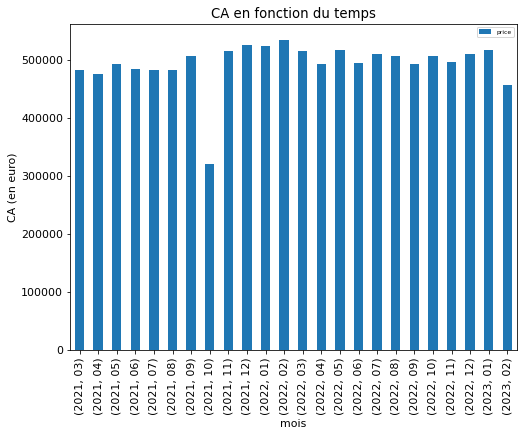

In [16]:
# je créer un bar chart pour observer l'évolution du CA au cours du temps
plt.rcParams.update({'font.size':11})
df_transaction_avec_info_prod[['price','year','month']].groupby(['year','month']).sum().plot.bar(figsize=(8,6))
plt.title('CA en fonction du temps')
plt.xlabel('mois')
plt.ylabel('CA (en euro)')
plt.legend(prop = {'size':6})

# je constate qu'il y a une baisse anormale de CA entre septembre et novembre 2021

In [17]:
df_transaction_avec_info_prod[df_transaction_avec_info_prod['year']=="2023"][
    df_transaction_avec_info_prod['month']== "02"]

<ipython-input-17-96b993008b1d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_transaction_avec_info_prod[df_transaction_avec_info_prod['year']=="2023"][


,id_prod,date,id_session,id_client,price,categ,_merge,year,month,day,time
653780,0_1451,2023-02-01 00:00:03,s_335178,c_1609,19.99,0,both,2023,02,01,00:00:03
653781,0_1425,2023-02-01 00:01:28,s_335179,c_2464,12.99,0,both,2023,02,01,00:01:28
653782,0_1341,2023-02-01 00:04:54,s_335173,c_1413,9.99,0,both,2023,02,01,00:04:54
653783,1_318,2023-02-01 00:05:34,s_335180,c_4207,17.24,1,both,2023,02,01,00:05:34
653784,2_102,2023-02-01 00:06:22,s_335176,c_93,59.14,2,both,2023,02,01,00:06:22
...,...,...,...,...,...,...,...,...,...,...,...
679327,1_508,2023-02-28 23:49:03,s_348444,c_3573,21.92,1,both,2023,02,28,23:49:03
679328,2_37,2023-02-28 23:51:29,s_348445,c_50,48.99,2,both,2023,02,28,23:51:29
679329,1_695,2023-02-28 23:53:18,s_348446,c_488,26.99,1,both,2023,02,28,23:53:18
679330,0_1547,2023-02-28 23:58:00,s_348447,c_4848,8.99,0,both,2023,02,28,23:58:00


### comprendre le CA d'octobre 2021

<ipython-input-18-68978f597013>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_transaction_avec_info_prod[df_transaction_avec_info_prod['year']=="2021"][


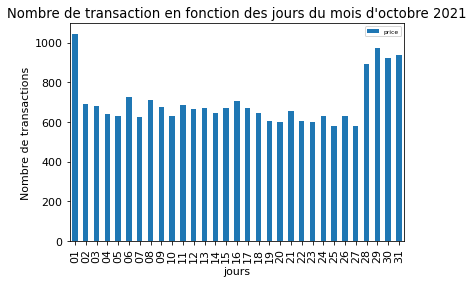

In [18]:
df_transaction_avec_info_prod[df_transaction_avec_info_prod['year']=="2021"][
    df_transaction_avec_info_prod['month']=="10"] [['price','day']].groupby(['day']).count().plot.bar(figsize=(6,4))
plt.title("Nombre de transaction en fonction des jours du mois d'octobre 2021")
plt.xlabel('jours')
plt.ylabel('Nombre de transactions')
plt.legend(prop = {'size':6})
# entre le 2 et le 27 octobre 2021 on a engistré netement moins de transaction qu'à notre habitude

Text(0, 0.5, 'Nombre de transaction')

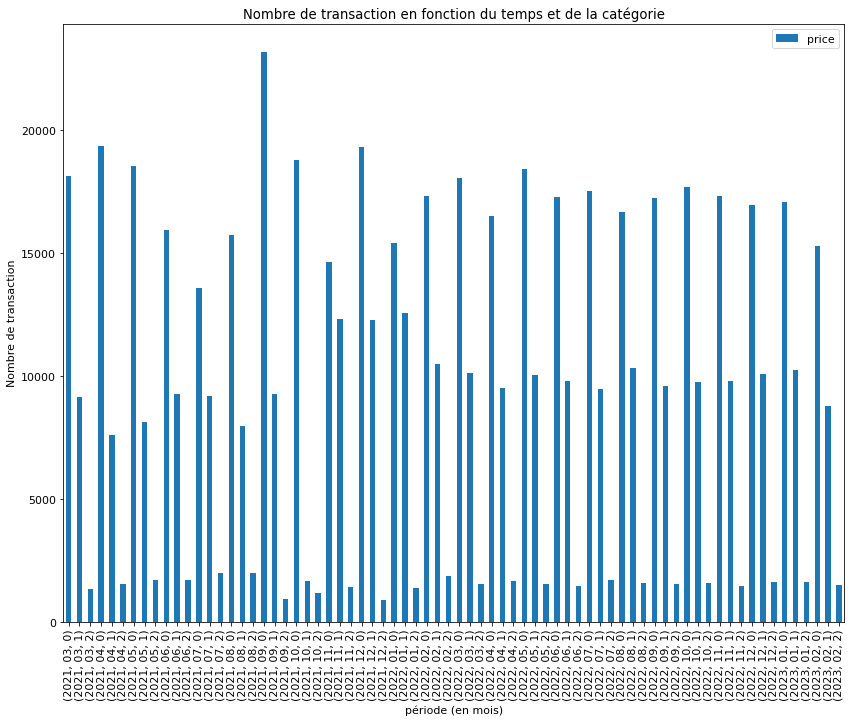

In [19]:
# si j'affiche le nombre de transaction en fonction du temps et de la catégorie de livre achetée 
# on constate que ce sont les ventes de livres de la catégories 1 qui sont anormalement faibles en octobre 2021
colors = {0.0:'blue',1.0:'red',2.0:'green'}
df_transaction_avec_info_prod[['price','year','month','categ']].groupby(['year','month','categ']).count().plot.bar(figsize=(11,8))
plt.title('Nombre de transaction en fonction du temps et de la catégorie')
plt.xlabel('période (en mois)')
plt.ylabel('Nombre de transaction')

Text(0, 0.5, "Chiffre d'affaire")

<Figure size 864x576 with 0 Axes>

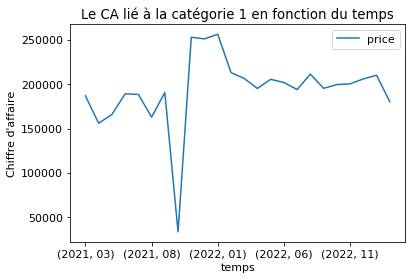

In [20]:
df_transaction_avec_info_prod[df_transaction_avec_info_prod['categ']==1][
    ['price','year','month']].groupby(['year','month']).sum().plot(figsize=(11,8))

plt.title("Le CA lié à la catégorie 1 en fonction du temps")
plt.xlabel('temps')
plt.ylabel("Chiffre d'affaire")

In [21]:
# je fais la moyenne des CA de l'année 2021
df_transaction_avec_info_prod[df_transaction_avec_info_prod['categ']==1][
    df_transaction_avec_info_prod['year']=='2021'][
        df_transaction_avec_info_prod['month']!="10"][
            ['price','month']].groupby(['month']).sum().mean()

<ipython-input-21-55e71cb7fb38>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_transaction_avec_info_prod[df_transaction_avec_info_prod['categ']==1][


price    193803.725556
dtype: float64

In [22]:
# le CA d'octobre est de 33762.32, il manque 156041
df_transaction_avec_info_prod[df_transaction_avec_info_prod['categ']==1][
    df_transaction_avec_info_prod['year']=='2021'][
        df_transaction_avec_info_prod['month']=="10"]['price'].sum()

<ipython-input-22-b902fb25b851>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_transaction_avec_info_prod[df_transaction_avec_info_prod['categ']==1][


33762.32000000001

In [23]:
# je créer un produit
len(df_products)

3288

In [24]:
df_products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0


In [25]:
df_products.loc[3289]=['1_ca10/21',156041,1]
df_products.describe()

,price,categ
count,3289.000000,3289.000000
mean,69.293293,0.370325
std,2720.646233,0.615331
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.090000,0.000000
75%,22.990000,1.000000
max,156041.000000,2.000000


In [26]:
# je créer une transaction
df_transactions.head()


,id_prod,date,id_session,id_client
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033


In [27]:
df_transactions.describe()

,id_prod,date,id_session,id_client
count,679332,679332,679332,679332
unique,3266,679332,342315,8600
top,1_369,2021-09-11 03:28:53.299092,s_118668,c_1609
freq,2252,1,14,25488


In [28]:
df_transactions.loc[679332]=['1_ca10/21','2021-10-05 12:00:00.000000','s_ca10/21',np.nan ]
df_transactions.loc[679332]

id_prod                        1_ca10/21
date          2021-10-05 12:00:00.000000
id_session                     s_ca10/21
id_client                            NaN
Name: 679332, dtype: object

In [29]:
# il faut refaire la jointure à présent
df_transaction_avec_info_prod = df_transactions.merge(df_products, how='left',indicator=True)
# je modifie la colonne date pour qu'elle occupe moins d'espace de stockage
df_transaction_avec_info_prod['date'] = df_transaction_avec_info_prod['date'].str[:19]
# pour étudier le chiffre d'affaire en fonction du temps, j'ajoute des colonnes
df_transaction_avec_info_prod['year'] = df_transaction_avec_info_prod['date'].str[:4]
df_transaction_avec_info_prod['month'] = df_transaction_avec_info_prod['date'].str[5:7]
df_transaction_avec_info_prod['day'] = df_transaction_avec_info_prod['date'].str[8:10]
df_transaction_avec_info_prod['time'] = df_transaction_avec_info_prod['date'].str[11:19]
df_transaction_avec_info_prod.head()

,id_prod,date,id_session,id_client,price,categ,_merge,year,month,day,time
0,0_1259,2021-03-01 00:01:07,s_1,c_329,11.99,0,both,2021,03,01,00:01:07
1,0_1390,2021-03-01 00:02:26,s_2,c_664,19.37,0,both,2021,03,01,00:02:26
2,0_1352,2021-03-01 00:02:38,s_3,c_580,4.50,0,both,2021,03,01,00:02:38
3,0_1458,2021-03-01 00:04:54,s_4,c_7912,6.55,0,both,2021,03,01,00:04:54
4,0_1358,2021-03-01 00:05:18,s_5,c_2033,16.49,0,both,2021,03,01,00:05:18


Text(0, 0.5, "Chiffre d'affaire")

<Figure size 864x576 with 0 Axes>

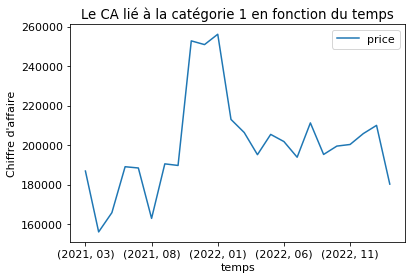

In [30]:
# le CA de la catégorie 1 dans le temps
plt.figure (figsize=(12,8))

df_transaction_avec_info_prod[df_transaction_avec_info_prod['categ']==1][
    ['price','year','month']].groupby(['year','month']).sum().plot()

plt.title("Le CA lié à la catégorie 1 en fonction du temps")
plt.xlabel('temps')
plt.ylabel("Chiffre d'affaire")

Text(0, 0.5, "Chiffre d'affaire")

<Figure size 864x576 with 0 Axes>

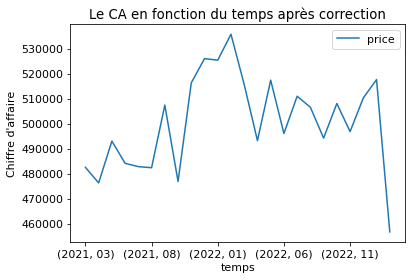

In [31]:
# le CA total dans le temps
plt.figure (figsize=(12,8))

df_transaction_avec_info_prod[['price','year','month']].groupby(['year','month']).sum().plot()

plt.title("Le CA en fonction du temps après correction")
plt.xlabel('temps')
plt.ylabel("Chiffre d'affaire")

### la moyenne mobile du CA  

No handles with labels found to put in legend.
No handles with labels found to put in legend.


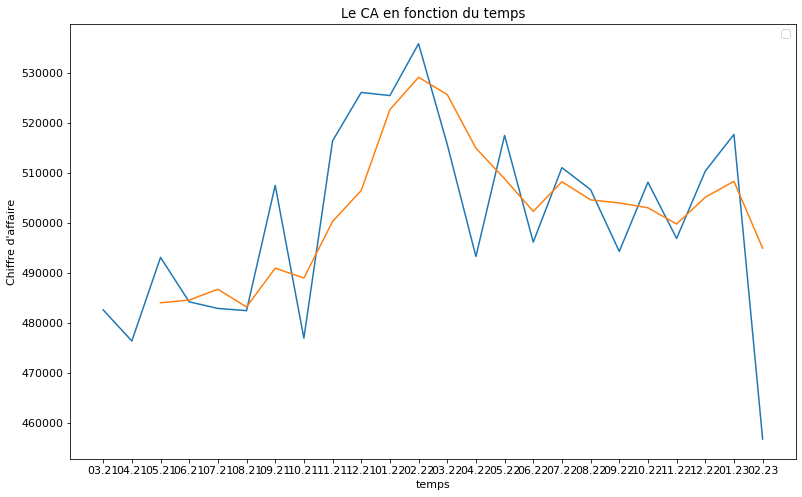

In [32]:
# chiffre d'affaire et chiffre d'affaire en moyenne mobile

plt.figure (figsize=(13,8))

df_ca_par_mois=df_transaction_avec_info_prod[['price','year','month']].groupby(['year','month']).sum()
df_ca_par_mois['période']=['03.21','04.21','05.21','06.21','07.21','08.21','09.21','10.21','11.21',
    '12.21','01.22','02.22','03.22','04.22','05.22','06.22','07.22','08.22','09.22','10.22','11.22','12.22','01.23','02.23']

plt.plot(df_ca_par_mois['période'],df_ca_par_mois['price'])
plt.plot(df_ca_par_mois['période'],df_ca_par_mois['price'].rolling(window=3).mean())

plt.title("Le CA en fonction du temps")
plt.xlabel('temps')
plt.ylabel("Chiffre d'affaire")
plt.legend(prop = {'size':6})

plt.legend()
plt.show()

## Analyse des ventes

In [33]:
# j'affiche les caractéristiques des prix des produits par catégorie
df_products[['price','categ']].groupby(['categ'],axis=0).describe()


price                                                             \
        count        mean          std    min      25%     50%       75%   
categ                                                                      
0      2310.0   11.731667     7.570053  -1.00   5.5825   10.32   16.6650   
1       740.0  236.363135  5735.263404   2.00  13.4100   22.99   34.0375   
2       239.0  108.354686    49.561431  30.99  71.0650  101.99  136.5300   

                  
             max  
categ             
0          40.99  
1      156041.00  
2         300.00

### les tops et les flops

In [34]:
# Les produits les moins vendus
df_transaction_avec_info_prod[['price','id_prod']].groupby(['id_prod']).count().sort_values(by='price').head(20)
# il faut y ajouter les quelques produits qui ont 0 ventes et qui n'ont pas été prit avec la left join

,price
id_prod,
2_98,1
0_1151,1
0_1683,1
0_1498,1
0_1379,1
0_2201,1
2_81,1
0_833,1
0_541,1


In [35]:
# les produits qui n'apparaissent pas dans les transactions
# je les considère comme des flops
df_transactions.merge(df_products, how='outer',indicator=True)[df_transactions.merge(df_products, how='outer',indicator=True)['_merge']=='right_only']

,id_prod,date,id_session,id_client,price,categ,_merge
679333,0_1016,NaN,NaN,NaN,35.06,0,right_only
679334,0_1780,NaN,NaN,NaN,1.67,0,right_only
679335,T_0,NaN,NaN,NaN,-1.00,0,right_only
679336,0_1062,NaN,NaN,NaN,20.08,0,right_only
679337,0_1119,NaN,NaN,NaN,2.99,0,right_only
679338,0_1014,NaN,NaN,NaN,1.15,0,right_only
679339,1_0,NaN,NaN,NaN,31.82,1,right_only
679340,0_1318,NaN,NaN,NaN,20.92,0,right_only
679341,0_1800,NaN,NaN,NaN,22.05,0,right_only
679342,0_1645,NaN,NaN,NaN,2.99,0,right_only


In [36]:
# les tops
df_transaction_avec_info_prod[['price','id_prod']].groupby(['id_prod']).count().sort_values(by='price',ascending=False).head(20)

,price
id_prod,
1_369,2252
1_417,2189
1_414,2180
1_498,2128
1_425,2096
1_403,1960
1_412,1951
1_413,1945
1_406,1939


### la répartition par catégorie

In [37]:
# je créer une colonne "nombre de vente" dans la table produit

df_products = pd.merge(df_products,df_transaction_avec_info_prod[['price','id_prod']].groupby(['id_prod']).count(),how='outer',left_on='id_prod',right_on='id_prod')
df_products.head()

,id_prod,price_x,categ,price_y
0,0_1421,19.99,0,1151.0
1,0_1368,5.13,0,919.0
2,0_731,17.99,0,16.0
3,1_587,4.99,1,119.0
4,0_1507,3.99,0,706.0


In [38]:
df_products.describe()

,price_x,categ,price_y
count,3289.000000,3289.000000,3267.000000
mean,69.293293,0.370325,207.937863
std,2720.646233,0.615331,331.280178
min,-1.000000,0.000000,1.000000
25%,6.990000,0.000000,17.000000
50%,13.090000,0.000000,57.000000
75%,22.990000,1.000000,239.000000
max,156041.000000,2.000000,2252.000000


In [39]:
# je renomme la collone price_y en "nombre de vente"
# je remplace les valeurs nulles en price_y par 0
df_products.columns = ['id_prod','price','categ','nombre de vente']
df_products = df_products.replace(np.nan,0)
df_products.describe()

,price,categ,nombre de vente
count,3289.000000,3289.000000,3289.000000
mean,69.293293,0.370325,206.546975
std,2720.646233,0.615331,330.604920
min,-1.000000,0.000000,0.000000
25%,6.990000,0.000000,16.000000
50%,13.090000,0.000000,56.000000
75%,22.990000,1.000000,236.000000
max,156041.000000,2.000000,2252.000000


array([<AxesSubplot:ylabel='price'>], dtype=object)

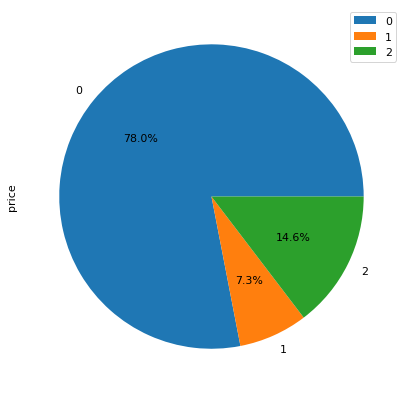

In [40]:
# je regarde la répartition des flops par catégorie
df_products[df_products['nombre de vente']<2][['categ','price']].groupby('categ').count().plot.pie(subplots=True,figsize=(7,7),autopct='%2.1f%%')

array([<AxesSubplot:ylabel='price'>], dtype=object)

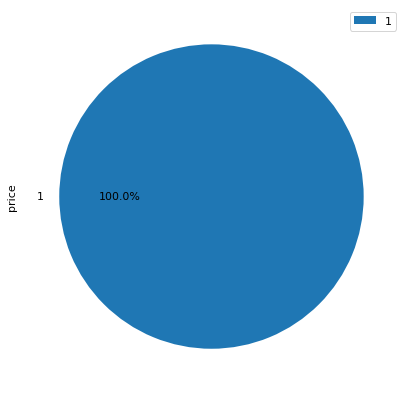

In [41]:
# je regarde la répartition des flops par catégorie
df_products[df_products['nombre de vente']>1500][['categ','price']].groupby('categ').count().plot.pie(subplots=True,figsize=(7,7),autopct='%2.1f%%')

## les profils de nos clients

### la répartition du CA par client

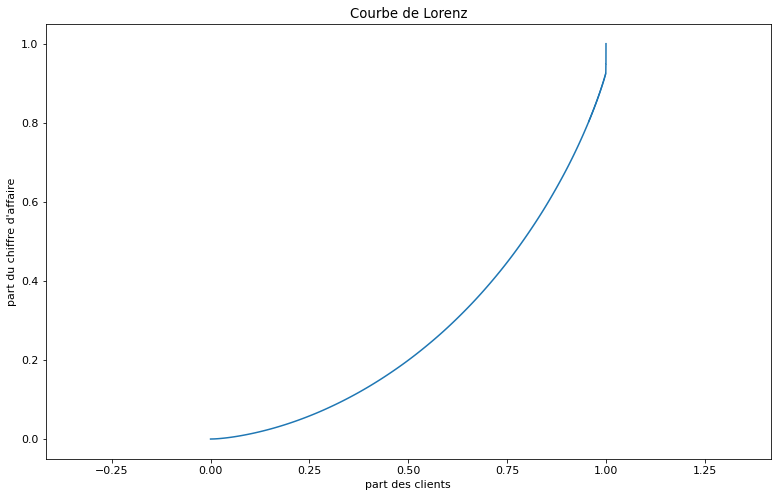

In [42]:
# courbe de lorenz / répartition du ca par client
fig, ax = plt.subplots(figsize=(13,8))


ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

dep = df_transaction_avec_info_prod[['price','id_client']].groupby(['id_client']).sum()['price']
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.axes().axis('equal')

xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')

plt.title("Courbe de Lorenz")
plt.xlabel('part des clients')
plt.ylabel("part du chiffre d'affaire")


plt.show()




## Analyse ciblé sur les clients

### le lien entre le genre d'un client et les catégories de livres achetés

In [43]:
# Je fais une jointure entre la table chiffre d'affaire et la table client
df_transaction_avec_info_prod_client = pd.merge(df_transaction_avec_info_prod,df_customers,how='inner',left_on='id_client',right_on='id_client')
df_transaction_avec_info_prod_client.head()

,id_prod,date,id_session,id_client,price,categ,_merge,year,month,day,time,sex,birth
0,0_1259,2021-03-01 00:01:07,s_1,c_329,11.99,0,both,2021,03,01,00:01:07,f,1967
1,1_498,2021-03-11 00:57:22,s_4624,c_329,23.37,1,both,2021,03,11,00:57:22,f,1967
2,0_1140,2021-03-16 10:01:30,s_7071,c_329,3.73,0,both,2021,03,16,10:01:30,f,1967
3,1_451,2021-03-18 17:26:18,s_8134,c_329,20.99,1,both,2021,03,18,17:26:18,f,1967
4,1_381,2021-04-25 13:26:06,s_25561,c_329,15.99,1,both,2021,04,25,13:26:06,f,1967


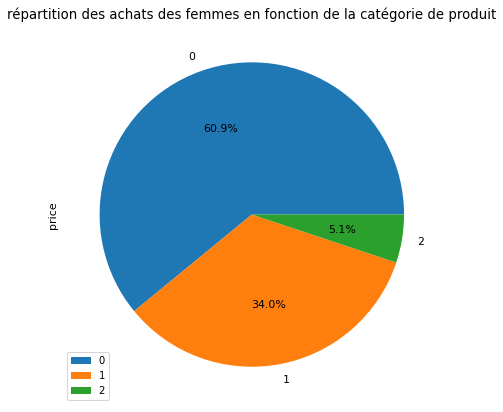

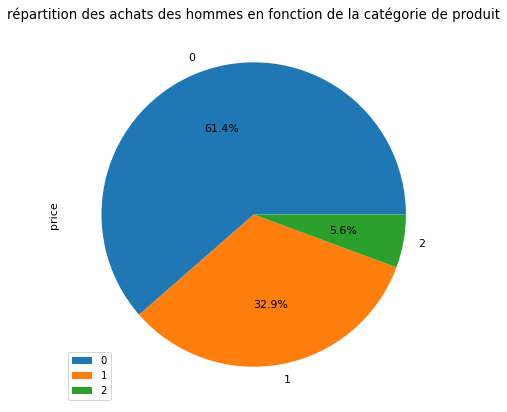

In [44]:
# je cherche à afficher un graphique avec la répartition des catégories de produit achetées par les femmes
df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['sex']=="f"][['categ','price']].groupby(['categ']).count().plot.pie(subplots=True,figsize=(7,7),autopct='%2.1f%%')
plt.title('répartition des achats des femmes en fonction de la catégorie de produit')
plt.legend(prop = {'size':10})

# je cherche à afficher un graphique avec la répartition des catégories de produit achetées par les hommes
df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['sex']=="m"][['categ','price']].groupby(['categ']).count().plot.pie(subplots=True,figsize=(7,7),autopct='%2.1f%%')
plt.title('répartition des achats des hommes en fonction de la catégorie de produit')
plt.legend(prop = {'size':10})

### le lien entre l'âge et le montant total des achats 

In [45]:
# je regroupe les transactions par client
df_transaction_avec_info_prod_client[ ['id_client','price']].groupby(['id_client']).sum()

,price
id_client,
c_1,558.18
c_10,1353.60
c_100,254.85
c_1000,2261.89
c_1001,1812.86
...,...
c_995,189.41
c_996,1625.58
c_997,1490.01


In [46]:
# je créer une nouvelle table client avec le ca total
df_customers_ca = pd.merge(df_transaction_avec_info_prod_client[
    ['id_client','price']].groupby(['id_client']).sum(),df_customers,how='outer',left_on='id_client',right_on='id_client',indicator = True)
df_customers_ca.columns = ['id_client','ca_total','sex','birth','_merge']
df_customers_ca [df_customers_ca['_merge']!='both']
# je constate que certains clients ne sont associés à aucune transaction, je pars du principe qu'ils n'ont jamais commandé de livre,

,id_client,ca_total,sex,birth,_merge
8600,c_8253,NaN,f,2001,right_only
8601,c_3789,NaN,f,1997,right_only
8602,c_4406,NaN,f,1998,right_only
8603,ct_0,NaN,f,2001,right_only
8604,c_2706,NaN,f,1967,right_only
8605,c_3443,NaN,m,1959,right_only
8606,c_4447,NaN,m,1956,right_only
8607,c_3017,NaN,f,1992,right_only
8608,c_4086,NaN,f,1992,right_only
8609,c_6930,NaN,m,2004,right_only


In [47]:
# je remplace les valeurs nulles par des 0, je considère que ce sont des clients qui n'ont passé aucune commande en ligne, leur ca est de 0
df_customers_ca [df_customers_ca['_merge']!='both'] = df_customers_ca [df_customers_ca['_merge']!='both'].replace(np.nan,0)
df_customers_ca[df_customers_ca['ca_total']==0].head()

,id_client,ca_total,sex,birth,_merge
8600,c_8253,0.0,f,2001,right_only
8601,c_3789,0.0,f,1997,right_only
8602,c_4406,0.0,f,1998,right_only
8603,ct_0,0.0,f,2001,right_only
8604,c_2706,0.0,f,1967,right_only


In [48]:
# je transforme la date de naissance en âge
df_customers_ca['birth']=2021-df_customers_ca['birth']
df_customers_ca.head()

,id_client,ca_total,sex,birth,_merge
0,c_1,558.18,m,66,both
1,c_10,1353.60,m,65,both
2,c_100,254.85,m,29,both
3,c_1000,2261.89,f,55,both
4,c_1001,1812.86,m,39,both


Text(0, 0.5, 'nombre de client')

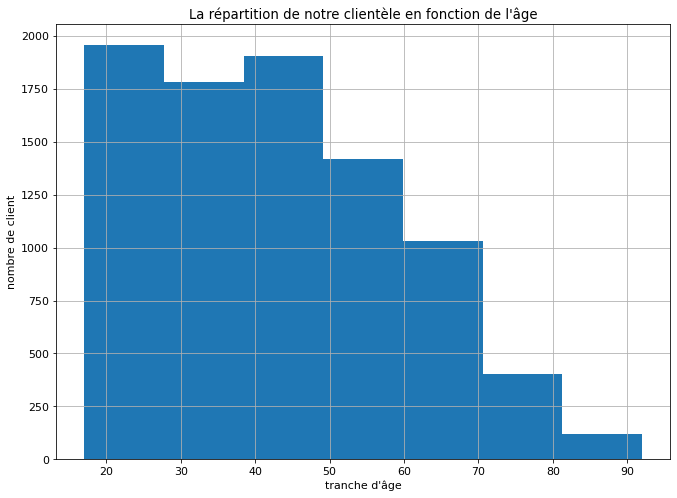

In [49]:
df_customers_ca['birth'].hist(bins=7, figsize=(11,8))

plt.title("La répartition de notre clientèle en fonction de l'âge")
plt.xlabel("tranche d'âge")
plt.ylabel('nombre de client')



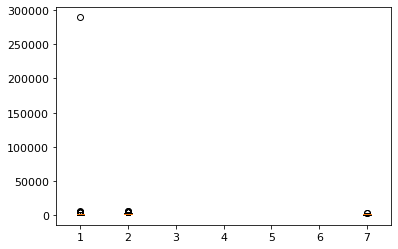

In [50]:
# j'affiche la répartition du ca total par client par catégorie d'âge
# des valeurs abérantes gènent la lisibilité des bloxplot
plt.boxplot(df_customers_ca[df_customers_ca['birth']<30]['ca_total'], positions=[1])
plt.boxplot(df_customers_ca[(df_customers_ca['birth']<40) & (df_customers_ca['birth']>29)]['ca_total'], positions=[2])
plt.boxplot(df_customers_ca[(df_customers_ca['birth']<50) & df_customers_ca['birth']>39]['ca_total'], positions=[3])
plt.boxplot(df_customers_ca[(df_customers_ca['birth']<60) & df_customers_ca['birth']>49]['ca_total'], positions=[4])
plt.boxplot(df_customers_ca[(df_customers_ca['birth']<70) & df_customers_ca['birth']>59]['ca_total'], positions=[5])
plt.boxplot(df_customers_ca[(df_customers_ca['birth']<80) & df_customers_ca['birth']>69]['ca_total'], positions=[6])
plt.boxplot(df_customers_ca[df_customers_ca['birth']>79]['ca_total'], positions=[7])
plt.show()

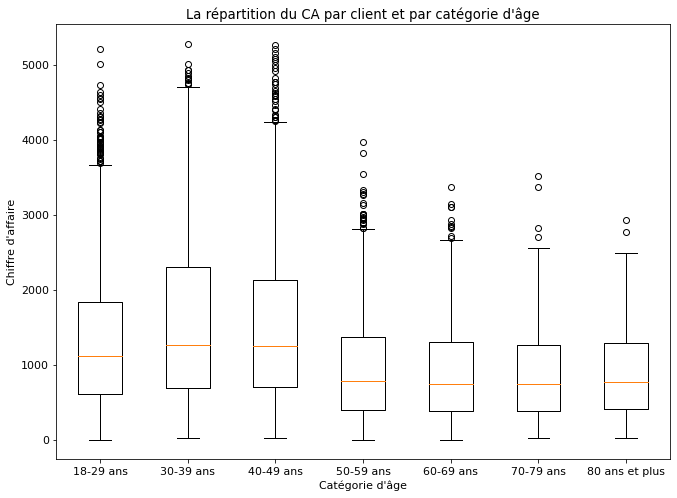

In [51]:
# autre manière d'afficher de multiples boxplot 
# je met un filtre pour enlever les valeurs abérantes
dict_repartition_ca_par_age = {'18-29 ans':df_customers_ca[(df_customers_ca['ca_total']<100000) & (
                                    df_customers_ca['birth']<30)]['ca_total'],
                               '30-39 ans':df_customers_ca[(df_customers_ca['ca_total']<100000) & (
                                   df_customers_ca['birth']<40) & (df_customers_ca['birth']>29)]['ca_total'],
                               '40-49 ans':df_customers_ca[(df_customers_ca['ca_total']<100000) & (
                                   df_customers_ca['birth']<50) & (df_customers_ca['birth']>39)]['ca_total'],
                               '50-59 ans':df_customers_ca[(df_customers_ca['ca_total']<100000) & (
                                   df_customers_ca['birth']<60) & (df_customers_ca['birth']>49)]['ca_total'],
                               '60-69 ans':df_customers_ca[(df_customers_ca['ca_total']<100000) & (
                                   df_customers_ca['birth']<70) & (df_customers_ca['birth']>59)]['ca_total'],
                               '70-79 ans':df_customers_ca[(df_customers_ca['ca_total']<100000) & (
                                   df_customers_ca['birth']<80) & (df_customers_ca['birth']>69)]['ca_total'],
                               '80 ans et plus':df_customers_ca[(df_customers_ca['ca_total']<100000) & (
                                   df_customers_ca['birth']>79)]['ca_total']
                              }
fig, ax = plt.subplots(figsize=(11,8))

ax.boxplot(dict_repartition_ca_par_age.values())
ax.set_xticklabels(dict_repartition_ca_par_age.keys())

ax.set_title("La répartition du CA par client et par catégorie d'âge")
ax.set_xlabel("Catégorie d'âge")
ax.set_ylabel("Chiffre d'affaire")

plt.show()

## la fréquence d'achat

In [52]:
df_transaction_avec_info_prod_client.head()

,id_prod,date,id_session,id_client,price,categ,_merge,year,month,day,time,sex,birth
0,0_1259,2021-03-01 00:01:07,s_1,c_329,11.99,0,both,2021,03,01,00:01:07,f,1967
1,1_498,2021-03-11 00:57:22,s_4624,c_329,23.37,1,both,2021,03,11,00:57:22,f,1967
2,0_1140,2021-03-16 10:01:30,s_7071,c_329,3.73,0,both,2021,03,16,10:01:30,f,1967
3,1_451,2021-03-18 17:26:18,s_8134,c_329,20.99,1,both,2021,03,18,17:26:18,f,1967
4,1_381,2021-04-25 13:26:06,s_25561,c_329,15.99,1,both,2021,04,25,13:26:06,f,1967


In [53]:
# je constate que la colonne date n'est pas de type datetime
df_transaction_avec_info_prod_client.dtypes

id_prod         object
date            object
id_session      object
id_client       object
price          float64
categ            int64
_merge        category
year            object
month           object
day             object
time            object
sex             object
birth            int64
dtype: object

In [54]:
# je transforme le type de la colonne date
df_transaction_avec_info_prod_client['date'] = pd.to_datetime(df_transaction_avec_info_prod_client['date'])

In [55]:
# je créer une table avec toutes les sessions, le prix total de chaque session et l'id client correspondant
df_session = df_transaction_avec_info_prod_client[['date','id_session','id_client']].merge(
    df_transaction_avec_info_prod[['id_session','price']].groupby(
        ['id_session']).sum(),how='outer',left_on='id_session',right_on='id_session')
df_session

,date,id_session,id_client,price
0,2021-03-01 00:01:07,s_1,c_329,11.99
1,2021-03-11 00:57:22,s_4624,c_329,23.37
2,2021-03-16 10:01:30,s_7071,c_329,3.73
3,2021-03-18 17:26:18,s_8134,c_329,20.99
4,2021-04-25 13:26:06,s_25561,c_329,15.99
...,...,...,...,...
679328,2022-04-18 23:45:11,s_196094,c_177,25.56
679329,2022-04-18 23:53:54,s_196094,c_177,25.56
679330,2023-02-18 23:45:11,s_343601,c_177,25.56
679331,2023-02-18 23:53:54,s_343601,c_177,25.56


In [56]:
# je sélectionne la commande la plus récente de chaque client
df_session[['date','id_client']].groupby(['id_client']).max()

,date
id_client,
c_1,2023-01-15 20:46:25
c_10,2023-01-27 03:39:36
c_100,2022-09-20 05:26:43
c_1000,2023-01-24 13:34:23
c_1001,2023-02-23 23:19:47
...,...
c_995,2022-11-21 14:20:58
c_996,2023-02-21 05:36:20
c_997,2023-02-05 02:02:14


In [57]:
# je sélectionne la commande la plus ancienne de chaque client
df_session[['date','id_client']].groupby(['id_client']).min()

,date
id_client,
c_1,2021-06-11 21:02:39
c_10,2021-03-21 02:50:16
c_100,2021-04-20 05:26:43
c_1000,2021-03-13 13:34:14
c_1001,2021-03-07 13:01:15
...,...
c_995,2021-04-08 02:50:33
c_996,2021-03-01 15:06:18
c_997,2021-04-30 19:41:32


In [58]:
# je compte le nombre de commande pour chaque client
df_session[['date','id_client']].groupby(['id_client']).count()

,date
id_client,
c_1,39
c_10,58
c_100,8
c_1000,125
c_1001,102
...,...
c_995,14
c_996,95
c_997,59


In [59]:
# je calcule la fréquence d'achat de chaque client
(df_session[['date','id_client']].groupby(['id_client']).max() - df_session[
    ['date','id_client']].groupby(['id_client']).min())/df_session[['date','id_client']].groupby(['id_client']).count()

,date
id_client,
c_1,14 days 22:45:44.256410256
c_10,11 days 16:09:07.586206896
c_100,64 days 18:00:00
c_1000,5 days 10:56:38.472000
c_1001,7 days 01:02:32.078431372
...,...
c_995,42 days 07:40:44.642857142
c_996,7 days 14:18:00.021052631
c_997,10 days 22:28:49.525423728


In [60]:
# j'ajoute une nouvelle colonne "fréquence d'achat" dans la table customer
df_customers_ca = pd.merge(df_customers_ca,(df_session[['date','id_client']].groupby(
    ['id_client']).max() - df_session[['date','id_client']].groupby(['id_client']).min())/df_session[
    ['date','id_client']].groupby(['id_client']).count(),how='outer',left_on='id_client',right_on='id_client')
df_customers_ca.columns = ['id_client','ca_total','sex','birth','_merge',"fréquence d'achat"]

df_customers_ca.head()


,id_client,ca_total,sex,birth,_merge,fréquence d'achat
0,c_1,558.18,m,66,both,14 days 22:45:44.256410256
1,c_10,1353.60,m,65,both,11 days 16:09:07.586206896
2,c_100,254.85,m,29,both,64 days 18:00:00
3,c_1000,2261.89,f,55,both,5 days 10:56:38.472000
4,c_1001,1812.86,m,39,both,7 days 01:02:32.078431372


In [61]:
df_customers_ca[df_customers_ca["fréquence d'achat"].isnull()==False].sort_values(by=["fréquence d'achat"])

,id_client,ca_total,sex,birth,_merge,fréquence d'achat
3855,c_4478,13.36,f,51,both,0 days 00:00:00
694,c_1624,28.54,m,29,both,0 days 00:00:00
5501,c_5962,13.99,f,24,both,0 days 00:00:00
3576,c_4223,24.81,f,70,both,0 days 00:00:00
5868,c_6292,24.24,m,29,both,0 days 00:00:00
...,...,...,...,...,...,...
3243,c_3923,34.48,f,17,both,259 days 00:00:00
3761,c_4391,363.98,f,20,both,259 days 00:00:00
4880,c_5401,55.88,m,37,both,259 days 00:00:00
8322,c_8506,97.98,f,20,both,259 days 00:00:00


<ipython-input-62-9fbf8aa09b70>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_customers_ca[df_customers_ca["fréquence d'achat"].isnull()==False][
<ipython-input-62-9fbf8aa09b70>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_customers_ca["fréquence d'achat"]!=0]['birth'],df_customers_ca[


Text(0, 0.5, "fréquence d'achat")

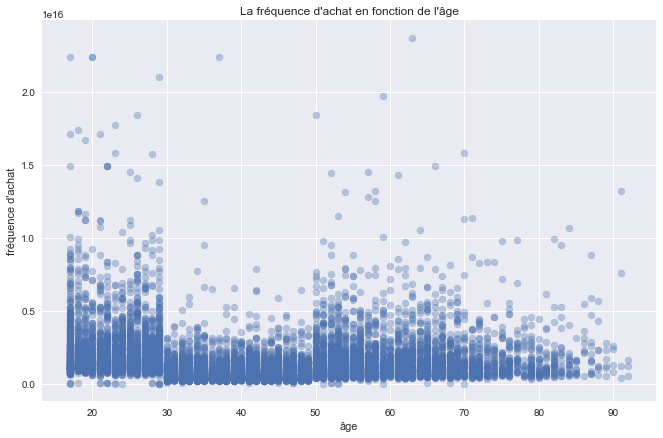

In [62]:
# 
# je met un filtre pour enlever les fréquence de 0 (les clients qui ont passé une seule commande)
# je met un filtre pour enlever les client qui n'ont pas de fréquence d'achat (les clients qui n'ont passé aucune commande)

plt.style.use('seaborn')

plt.figure(figsize=(11,7))
plt.scatter(df_customers_ca[df_customers_ca["fréquence d'achat"].isnull()==False][
    df_customers_ca["fréquence d'achat"]!=0]['birth'],df_customers_ca[
        df_customers_ca["fréquence d'achat"].isnull()==False][
            df_customers_ca["fréquence d'achat"]!=0]["fréquence d'achat"] ,alpha=0.35)



plt.title("La fréquence d'achat en fonction de l'âge")
plt.xlabel('âge')
plt.ylabel("fréquence d'achat")




## la taille du panier moyen

In [63]:
# je rassemble les transactions par session pour aubtenir la valeur de chaque panier
df_transaction_avec_info_prod[['id_session','price']].groupby(['id_session']).sum()

,price
id_session,
s_1,11.99
s_10,26.99
s_100,33.72
s_1000,39.22
s_10000,41.49
...,...
s_99995,19.84
s_99996,56.27
s_99997,6.99


In [64]:
# je créer une table avec toutes les sessions, le prix total de chaque session et l'id client correspondant
# attention je créer cette table à la question d'avant
df_transaction_avec_info_prod_client[['date','id_session','id_client']].merge(
    df_transaction_avec_info_prod[['id_session','price']].groupby(['id_session']).sum(),how='outer',left_on='id_session',right_on='id_session')

,date,id_session,id_client,price
0,2021-03-01 00:01:07,s_1,c_329,11.99
1,2021-03-11 00:57:22,s_4624,c_329,23.37
2,2021-03-16 10:01:30,s_7071,c_329,3.73
3,2021-03-18 17:26:18,s_8134,c_329,20.99
4,2021-04-25 13:26:06,s_25561,c_329,15.99
...,...,...,...,...
679328,2022-04-18 23:45:11,s_196094,c_177,25.56
679329,2022-04-18 23:53:54,s_196094,c_177,25.56
679330,2023-02-18 23:45:11,s_343601,c_177,25.56
679331,2023-02-18 23:53:54,s_343601,c_177,25.56


In [65]:
# je calcule à présent le panier moyen par client
df_transaction_avec_info_prod_client[['date','id_session','id_client']].merge(
    df_transaction_avec_info_prod[['id_session','price']].groupby(
        ['id_session']).sum(),how='outer',left_on='id_session',right_on='id_session')[['id_client','price']].groupby('id_client').mean()

,price
id_client,
c_1,26.083077
c_10,49.353448
c_100,64.761250
c_1000,34.830400
c_1001,59.886275
...,...
c_995,22.061429
c_996,23.328737
c_997,66.010678


In [66]:
# j'ajoute les données de cette table à la table df_customers_ca
df_customers_ca = df_customers_ca.merge(df_transaction_avec_info_prod_client[
    ['date','id_session','id_client']].merge(
        df_transaction_avec_info_prod[['id_session','price']].groupby(
            ['id_session']).sum(),how='outer',left_on='id_session',right_on='id_session')[
                ['id_client','price']].groupby('id_client').mean(),how='outer',left_on='id_client',right_on='id_client')
df_customers_ca
# les clients qui n'ont passé aucune commande n'ont pas de valeur de panier moyen, il faut en tenir compte

,id_client,ca_total,sex,birth,_merge,fréquence d'achat,price
0,c_1,558.18,m,66,both,14 days 22:45:44.256410256,26.083077
1,c_10,1353.60,m,65,both,11 days 16:09:07.586206896,49.353448
2,c_100,254.85,m,29,both,64 days 18:00:00,64.761250
3,c_1000,2261.89,f,55,both,5 days 10:56:38.472000,34.830400
4,c_1001,1812.86,m,39,both,7 days 01:02:32.078431372,59.886275
...,...,...,...,...,...,...,...
8618,c_7584,0.00,f,61,right_only,NaT,NaN
8619,c_90,0.00,m,20,right_only,NaT,NaN
8620,c_587,0.00,m,28,right_only,NaT,NaN
8621,ct_1,0.00,m,20,right_only,NaT,NaN


<ipython-input-67-6545bbb07a1e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  '18-29 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
<ipython-input-67-6545bbb07a1e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  '30-39 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
<ipython-input-67-6545bbb07a1e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  '30-39 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
<ipython-input-67-6545bbb07a1e>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  '40-49 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
<ipython-input-67-6545bbb07a1e>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  '40-49 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
<ipython-input-67-6545bbb07a1e>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.

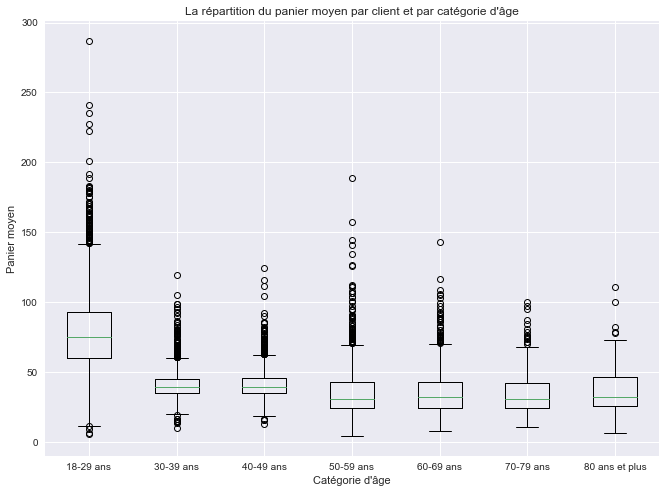

In [67]:
dict_repartition_panier_moyen_par_age = {
    '18-29 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
        df_customers_ca['birth']<30]['price'],
    '30-39 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
        df_customers_ca['birth']<40][df_customers_ca['birth']>29]['price'],
    '40-49 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
        df_customers_ca['birth']<50][df_customers_ca['birth']>39]['price'],
    '50-59 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
        df_customers_ca['birth']<60][df_customers_ca['birth']>49]['price'],
    '60-69 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
        df_customers_ca['birth']<70][df_customers_ca['birth']>59]['price'],
    '70-79 ans': df_customers_ca[df_customers_ca['_merge']=='both'][
        df_customers_ca['birth']<80][df_customers_ca['birth']>69]['price'],
    '80 ans et plus': df_customers_ca[df_customers_ca['_merge']=='both'][
        df_customers_ca['birth']>79]['price']
}
    
fig, ax = plt.subplots(figsize=(11,8))

ax.boxplot(dict_repartition_panier_moyen_par_age.values())
ax.set_xticklabels(dict_repartition_ca_par_age.keys())

ax.set_title("La répartition du panier moyen par client et par catégorie d'âge")
ax.set_xlabel("Catégorie d'âge")
ax.set_ylabel("Panier moyen")

plt.show()

### mesures de tendance centrale

In [68]:
# moyenne
df_customers_ca[df_customers_ca['price'].isnull() == False]['price'].mean()

49.249638820076406

In [69]:
# médiane
np.median(df_customers_ca[df_customers_ca['price'].isnull() == False]['price'])

41.28882716049382

### mesures de dispersion

In [70]:
# variance
np.var(df_customers_ca[df_customers_ca['price'].isnull() == False]['price'])

689.076986377506

In [71]:
# écart type
np.std(df_customers_ca[df_customers_ca['price'].isnull() == False]['price'])

26.250275929549883

### mesure de forme

In [72]:
# le skewness empirique
skew(df_customers_ca[df_customers_ca['price'].isnull() == False]['price'])

1.7399229347996283

## les catégories de livre achetés en fonction de l'âge

In [73]:
# je vais utiliser la table df_transaction_avec_info_prod car elle contient la catégorie de chaque livre acheté et l'âge du client corrrespondant
df_transaction_avec_info_prod_client.head()

,id_prod,date,id_session,id_client,price,categ,_merge,year,month,day,time,sex,birth
0,0_1259,2021-03-01 00:01:07,s_1,c_329,11.99,0,both,2021,03,01,00:01:07,f,1967
1,1_498,2021-03-11 00:57:22,s_4624,c_329,23.37,1,both,2021,03,11,00:57:22,f,1967
2,0_1140,2021-03-16 10:01:30,s_7071,c_329,3.73,0,both,2021,03,16,10:01:30,f,1967
3,1_451,2021-03-18 17:26:18,s_8134,c_329,20.99,1,both,2021,03,18,17:26:18,f,1967
4,1_381,2021-04-25 13:26:06,s_25561,c_329,15.99,1,both,2021,04,25,13:26:06,f,1967


In [74]:
# je transforme "birth" en âge
df_transaction_avec_info_prod_client['birth']=2021-df_transaction_avec_info_prod_client['birth']
df_transaction_avec_info_prod_client.columns = ['id_prod','date','id_session','id_client','price','categ','_merge','year','month','day','time','sex','age']
df_transaction_avec_info_prod_client.head()

,id_prod,date,id_session,id_client,price,categ,_merge,year,month,day,time,sex,age
0,0_1259,2021-03-01 00:01:07,s_1,c_329,11.99,0,both,2021,03,01,00:01:07,f,54
1,1_498,2021-03-11 00:57:22,s_4624,c_329,23.37,1,both,2021,03,11,00:57:22,f,54
2,0_1140,2021-03-16 10:01:30,s_7071,c_329,3.73,0,both,2021,03,16,10:01:30,f,54
3,1_451,2021-03-18 17:26:18,s_8134,c_329,20.99,1,both,2021,03,18,17:26:18,f,54
4,1_381,2021-04-25 13:26:06,s_25561,c_329,15.99,1,both,2021,04,25,13:26:06,f,54


In [75]:
# je créer une table qui me donne la répartition des achats par catégorie par rapport à une tranche d'âge
df_transaction_avec_info_prod_client[
    df_transaction_avec_info_prod_client['age']<30][['categ','age']].groupby(
        ['categ']).count() / df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['age']<30]['categ'].count()

#df_categ_par_age['age']


,age
categ,
0,0.209134
1,0.375354
2,0.415513


In [76]:
# de la même manière je créer 7 tables, une par segment d'âge
df_categ_par_age_1 = df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['age']<30][
    ['categ','age']].groupby(['categ']).count()/df_transaction_avec_info_prod_client[
        df_transaction_avec_info_prod_client['age']<30]['categ'].count()*100

df_categ_par_age_2 = df_transaction_avec_info_prod_client[(df_transaction_avec_info_prod_client['age']<40) & (
    df_transaction_avec_info_prod_client['age']>29)][['categ','age']].groupby(
        ['categ']).count()/df_transaction_avec_info_prod_client[
            (df_transaction_avec_info_prod_client['age']<40) & (
                df_transaction_avec_info_prod_client['age']>29)]['categ'].count()*100

df_categ_par_age_3 = df_transaction_avec_info_prod_client[(df_transaction_avec_info_prod_client['age']<50) & (
    df_transaction_avec_info_prod_client['age']>39)][['categ','age']].groupby(
        ['categ']).count()/df_transaction_avec_info_prod_client[
            df_transaction_avec_info_prod_client['age']<50][
                df_transaction_avec_info_prod_client['age']>39]['categ'].count()*100

df_categ_par_age_4 = df_transaction_avec_info_prod_client[(df_transaction_avec_info_prod_client['age']<60) & (
    df_transaction_avec_info_prod_client['age']>49)][['categ','age']].groupby(
        ['categ']).count()/df_transaction_avec_info_prod_client[
            df_transaction_avec_info_prod_client['age']<60][
                df_transaction_avec_info_prod_client['age']>49]['categ'].count()*100

df_categ_par_age_5 = df_transaction_avec_info_prod_client[(df_transaction_avec_info_prod_client['age']<70) & (
    df_transaction_avec_info_prod_client['age']>59)][['categ','age']].groupby(
        ['categ']).count()/df_transaction_avec_info_prod_client[
            df_transaction_avec_info_prod_client['age']<70][
                df_transaction_avec_info_prod_client['age']>59]['categ'].count()*100

df_categ_par_age_6 = df_transaction_avec_info_prod_client[(df_transaction_avec_info_prod_client['age']<80) & (
    df_transaction_avec_info_prod_client['age']>69)][['categ','age']].groupby(
        ['categ']).count()/df_transaction_avec_info_prod_client[
            df_transaction_avec_info_prod_client['age']<80][
                df_transaction_avec_info_prod_client['age']>69]['categ'].count()*100

df_categ_par_age_7 = df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['age']>79][
    ['categ','age']].groupby(['categ']).count()/df_transaction_avec_info_prod_client[
        df_transaction_avec_info_prod_client['age']>79]['categ'].count()*100

<ipython-input-76-e7354aaf0c81>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ['categ']).count()/df_transaction_avec_info_prod_client[
<ipython-input-76-e7354aaf0c81>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ['categ']).count()/df_transaction_avec_info_prod_client[
<ipython-input-76-e7354aaf0c81>:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ['categ']).count()/df_transaction_avec_info_prod_client[
<ipython-input-76-e7354aaf0c81>:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ['categ']).count()/df_transaction_avec_info_prod_client[


In [77]:
# je renomme les colonnes âge
df_categ_par_age_1.columns = ['entre 18 et 29 ans']
df_categ_par_age_2.columns = ['entre 30 et 39 ans']
df_categ_par_age_3.columns = ['entre 40 et 49 ans']
df_categ_par_age_4.columns = ['entre 50 et 59 ans']
df_categ_par_age_5.columns = ['entre 60 et 69 ans']
df_categ_par_age_6.columns = ['entre 70 et 79 ans']
df_categ_par_age_7.columns = ['plus de 80 ans']

In [78]:
# j'assemble les 7 dataframes
df_categ_par_age = pd.concat([df_categ_par_age_1,df_categ_par_age_2,df_categ_par_age_3,df_categ_par_age_4,df_categ_par_age_5,df_categ_par_age_6,df_categ_par_age_7],axis=1)
df_categ_par_age

,entre 18 et 29 ans,entre 30 et 39 ans,entre 40 et 49 ans,entre 50 et 59 ans,entre 60 et 69 ans,entre 70 et 79 ans,plus de 80 ans
categ,,,,,,,
0,20.913371,76.166667,76.302030,44.428398,43.622531,43.767057,42.979912
1,37.535375,23.452090,23.367026,54.499361,55.447167,55.326333,56.021055
2,41.551253,0.381244,0.330945,1.072241,0.930303,0.906610,0.999033


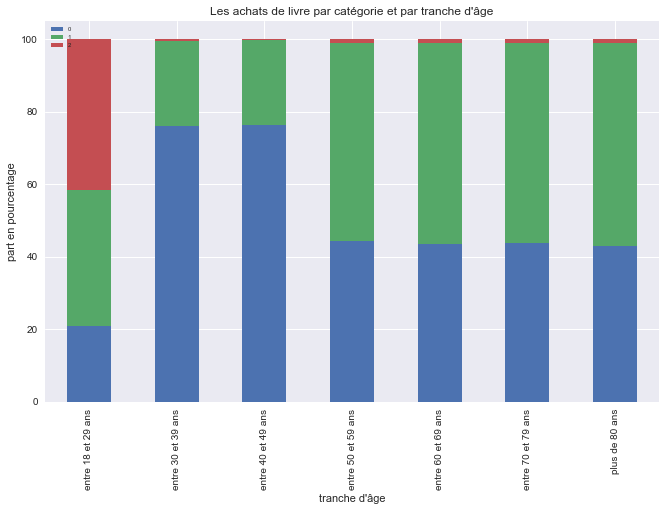

In [79]:
# j'affiche le graphique de la réppartition d'achat de livre par catégorie et par tranche d'âge
pd.DataFrame({'0':df_categ_par_age.iloc[0,:],'1':df_categ_par_age.iloc[1,:],'2':df_categ_par_age.iloc[2,:]}).plot.bar(stacked=True,figsize=(11,7))

plt.title("Les achats de livre par catégorie et par tranche d'âge")
plt.xlabel("tranche d'âge")
plt.ylabel("part en pourcentage")
plt.legend(prop = {'size':6})

In [80]:
pd.DataFrame({'0':df_categ_par_age.iloc[0,:],'1':df_categ_par_age.iloc[1,:],'2':df_categ_par_age.iloc[2,:]})

,0,1,2
entre 18 et 29 ans,20.913371,37.535375,41.551253
entre 30 et 39 ans,76.166667,23.452090,0.381244
entre 40 et 49 ans,76.302030,23.367026,0.330945
entre 50 et 59 ans,44.428398,54.499361,1.072241
entre 60 et 69 ans,43.622531,55.447167,0.930303
entre 70 et 79 ans,43.767057,55.326333,0.906610
plus de 80 ans,42.979912,56.021055,0.999033


## la corrélation entre l'achat du 2_159 et 0_525

In [81]:
# j'isole la liste des clients qui ont acheté le produit 2_159
df_client_2159 = df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['id_prod']=="2_159"][
    'id_client'].drop_duplicates()
df_client_2159

4641      c_1609
29465     c_2711
29740     c_5714
31713     c_3454
36820     c_5682
           ...  
675636    c_6276
676041    c_6845
676136    c_7412
677045    c_5710
677748    c_2105
Name: id_client, Length: 530, dtype: object

In [82]:
# j'isole la liste des clients qui ont acheté le produit 0_525
df_client_0525 = df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['id_prod']=="0_525"][
    'id_client'].drop_duplicates()
df_client_0525

4642      c_1609
29741     c_5714
31714     c_3454
36821     c_5682
37311     c_1478
           ...  
672627    c_2390
675493    c_8262
676042    c_6845
676137    c_7412
677749    c_2105
Name: id_client, Length: 459, dtype: object

In [83]:
# j'isole les clients qui ont acheté les 2 produits
pd.merge(df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['id_prod']=="2_159"][
    'id_client'].drop_duplicates(),df_transaction_avec_info_prod_client[
        df_transaction_avec_info_prod_client['id_prod']=="0_525"]['id_client'].drop_duplicates(),how='inner',left_on='id_client',right_on='id_client')

,id_client
0,c_1609
1,c_5714
2,c_3454
3,c_5682
4,c_1478
...,...
454,c_2390
455,c_8262
456,c_6845
457,c_7412


In [84]:
# la probabilité que les client aient acheté le produit 0_525 alors qu'ils ont acheté le produit 2_159
pd.merge(df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client['id_prod']=="2_159"][
    'id_client'].drop_duplicates(),df_transaction_avec_info_prod_client[df_transaction_avec_info_prod_client[
        'id_prod']=="0_525"]['id_client'].drop_duplicates(
            ),how='inner',left_on='id_client',right_on='id_client').count()/df_transaction_avec_info_prod_client[
                df_transaction_avec_info_prod_client['id_prod']=="2_159"]['id_client'].drop_duplicates().count()*100

id_client    86.603774
dtype: float64